In [ ]:
#Importing librariries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, roc_auc_score,roc_curve, precision_recall_curve, confusion_matrix, classification_report)
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
#Loading the pre processsed dataset
df = pd.read_csv("processed_stroke_dataset.csv")
print(df.shape)
df.head()

(15000, 51)


,Age,Gender,Hypertension,Heart Disease,Average Glucose Level,Body Mass Index (BMI),Stroke History,Family History of Stroke,Stress Levels,Diagnosis,...,Confusion,Difficulty Speaking,Dizziness,Headache,Loss of Balance,Numbness,Seizures,Severe Fatigue,Unknown,Weakness
0,0.527778,0,0,1,0.506500,0.294518,0,1,0.348,1,...,0,1,0,1,0,0,0,0,0,0
1,0.861111,0,0,0,0.883786,0.702681,0,0,0.173,1,...,1,0,1,1,1,0,0,0,0,0
2,0.111111,0,1,1,0.921429,0.212485,0,1,0.731,1,...,0,0,1,0,0,0,1,0,0,0
3,0.763889,0,0,0,0.894929,0.499800,0,0,0.535,0,...,1,0,0,1,0,0,1,1,0,0
4,0.458333,0,1,1,0.838143,0.562225,0,1,0.684,1,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
TARGET_COL = 'Diagnosis'  #1=Stroke, 0=No Stroke

#Seperating target column from features
y = df[TARGET_COL].astype('float32').values
X = df.drop(columns=[TARGET_COL])

print("Features:", X.shape, "| Target:", y.shape)
print("Positive rate (mean of y):", y.mean().round(4))

Features: (15000, 50) | Target: (15000,)
Positive rate (mean of y): 0.4979


In [ ]:
#Split dataset to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.20, random_state=42, stratify=y)

input_dim = X_train.shape[1]
print("Input dimensions:", input_dim)

Input dimensions: 50


In [ ]:
#Function for building the Multi-Layer Perceptron
def build_mlp(input_dim, hidden_layers, dropout, l2_reg, lr):

    #Creating a straight stack of layers
    model = keras.Sequential(name="Stroke_MLP")
    model.add(layers.Input(shape=(input_dim,)))

    #One full connected layer(Dense) is added for each entry in hidden layers list
    #Uses ReLu activation fucntion for efficiency and to avoid vanishing gradients
    #L2 regularization keeps weights small and stable
    for units in hidden_layers:
        model.add(layers.Dense(units, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)))
        if dropout and dropout > 0:     #Applied after each dense layer to reduces overfitting
            model.add(layers.Dropout(dropout))

    #Adding the final neuron for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),]
        )

    return model

In [ ]:
#Calling the created function, to build the MLP
model = build_mlp(input_dim=input_dim, hidden_layers=(256, 128, 64), dropout=0.3, l2_reg=1e-4, lr=1e-3)

#Displaying layer names, output shapes and number of parameters
model.summary()

Model: "Stroke_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 256)            │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,273 (212.00 KB)

 Trainable params: 54,273 (212.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Monitioring validation loss using callbacks

#Used to prevent overfitting and save training time
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    mode = 'max',
    patience=30,      #Stop training if it does not improve over given number of epochs
    restore_best_weights=True     #Restoring weights that achieved the lowest validation loss
)


#Reducing learning rate if loss value stops decreasing during learning
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode = 'max',
    factor=0.5,
    patience=5,
    min_lr=1e-6,    #Keeps lowering learning rate until it hits this value
    verbose=1
)


#Keeeping the best version of the model; for reusability and ease of deployment
checkpoint_path = "best_mlp.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_auc",  # watch AUC
    mode="max",
    save_best_only=True,
    verbose=1
)

In [ ]:
#Training the MLP
BATCH_SIZE = 64   #Model updates after processing this number of samples; speeds up learning
EPOCHS = 120    #Defines how many full passes of the entire training data to go through; may stop early

#Recording losses and metrics at each epoch for later plotting
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  #Validate performance using 20% of training data
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr, checkpoint],  #Applying previously defined callbacks
    verbose=1
)


Epoch 1/120
145/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4934 - auc: 0.4891 - loss: 0.7359 - precision: 0.4920 - recall: 0.4306
Epoch 1: val_auc improved from -inf to 0.47462, saving model to best_mlp.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4938 - auc: 0.4897 - loss: 0.7356 - precision: 0.4922 - recall: 0.4304 - val_accuracy: 0.4888 - val_auc: 0.4746 - val_loss: 0.7257 - val_precision: 0.4959 - val_recall: 0.5992 - learning_rate: 0.0010
Epoch 2/120
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5111 - auc: 0.5181 - loss: 0.7228 - precision: 0.5061 - recall: 0.4949
Epoch 2: val_auc improved from 0.47462 to 0.48682, saving model to best_mlp.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5109 - auc: 0.5179 - loss: 0.7228 - precision: 0.5060 - recall: 0.4946 - val_accuracy: 0.4783 - val_auc: 0.4868 - val_loss: 0.7216 - val_precision: 0.4721 - val_recall: 0.2576 - learning_rate: 0.0010
Epoch 3/120
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5211 - auc: 0.5255 - loss: 0.7192 - precision: 0.5238 - recall: 0.3703
Epoch 3: val_auc did not improve from 0.48682
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5210 - auc: 0.5255 - loss: 0.7192 - precision: 0.5237 - recall: 0.3713 - val_accuracy: 0.4750 - val_auc: 0.4728 - val_loss: 0.7207 - val_precision: 0.4512 - val_recall: 0.1712 - learning_rate: 0.0010
Epoch 4/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5173 - auc: 0.5226 - loss: 0.7162 - precision: 0.5120 - recall: 0.3974
Epoch 4: val_auc improved from 0.48682 to 0.48781, saving model to best_mlp.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5173 - auc: 0.5226 - loss: 0.7162 - precision: 0.5120 - recall: 0.3976 - val_accuracy: 0.5058 - val_auc: 0.4878 - val_loss: 0.7165 - val_precision: 0.5071 - val_recall: 0.8494 - learning_rate: 0.0010
Epoch 5/120
146/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5157 - auc: 0.5318 - loss: 0.7134 - precision: 0.5087 - recall: 0.5205
Epoch 5: val_auc did not improve from 0.48781
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5158 - auc: 0.5318 - loss: 0.7133 - precision: 0.5090 - recall: 0.5191 - val_accuracy: 0.4808 - val_auc: 0.4730 - val_loss: 0.7170 - val_precision: 0.4863 - val_recall: 0.4527 - learning_rate: 0.0010
Epoch 6/120
145/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5362 - auc: 0.5451 - loss: 0.7101 - precision: 0.5328 - recall: 0.5285
Epoch 6: val_auc did not improve from 0.48781
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5359 - auc: 0.5448 - loss: 0.7101 - precision: 0.5326 - recall: 0.5

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6093 - auc: 0.6522 - loss: 0.6713 - precision: 0.6051 - recall: 0.5808 - val_accuracy: 0.4975 - val_auc: 0.4940 - val_loss: 0.7280 - val_precision: 0.5038 - val_recall: 0.4971 - learning_rate: 5.0000e-04
Epoch 15/120
140/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6120 - auc: 0.6543 - loss: 0.6716 - precision: 0.6141 - recall: 0.5857
Epoch 15: val_auc did not improve from 0.49397
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6125 - auc: 0.6546 - loss: 0.6715 - precision: 0.6147 - recall: 0.5860 - val_accuracy: 0.4946 - val_auc: 0.4916 - val_loss: 0.7456 - val_precision: 0.5008 - val_recall: 0.5144 - learning_rate: 5.0000e-04
Epoch 16/120
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6258 - auc: 0.6738 - loss: 0.6615 - precision: 0.6288 - recall: 0.5918
Epoch 16: val_auc did not improve from 0.49397
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6257 - auc: 0.6737 - loss: 0.6616 - precision: 0.6288 -

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6353 - auc: 0.6895 - loss: 0.6521 - precision: 0.6404 - recall: 0.5918 - val_accuracy: 0.5029 - val_auc: 0.4988 - val_loss: 0.7455 - val_precision: 0.5144 - val_recall: 0.3243 - learning_rate: 5.0000e-04
Epoch 18/120
141/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6383 - auc: 0.6953 - loss: 0.6496 - precision: 0.6545 - recall: 0.6031
Epoch 18: val_auc did not improve from 0.49883
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6380 - auc: 0.6948 - loss: 0.6498 - precision: 0.6536 - recall: 0.6031 - val_accuracy: 0.4950 - val_auc: 0.4926 - val_loss: 0.7559 - val_precision: 0.5017 - val_recall: 0.3728 - learning_rate: 5.0000e-04
Epoch 19/120
141/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6587 - auc: 0.7175 - loss: 0.6340 - precision: 0.6710 - recall: 0.5988
Epoch 19: val_auc did not improve from 0.49883
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6579 - auc: 0.7165 - loss: 0.6346 - precision: 0.6699 -

In [ ]:
from pathlib import Path
#Reload best weights (if checkpoint with highest validation AUC)
if Path(checkpoint_path).exists():
    model.load_weights(checkpoint_path)

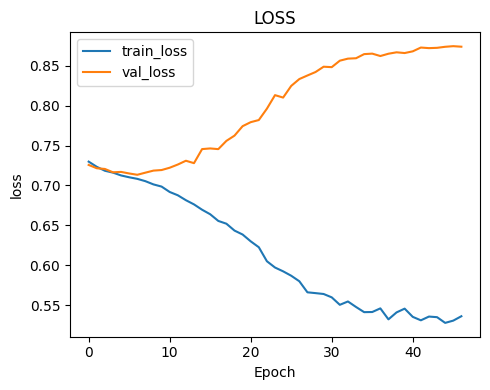

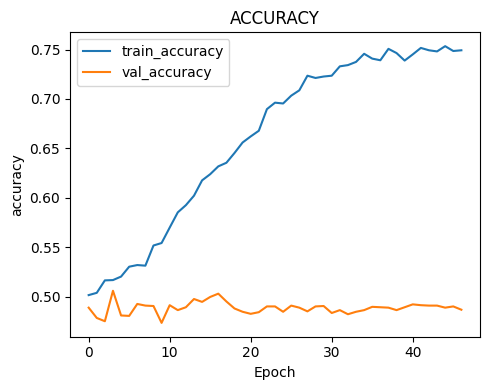

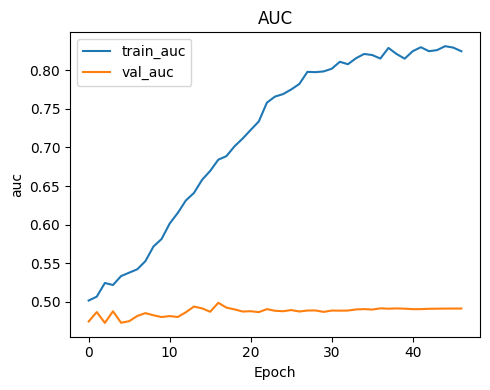

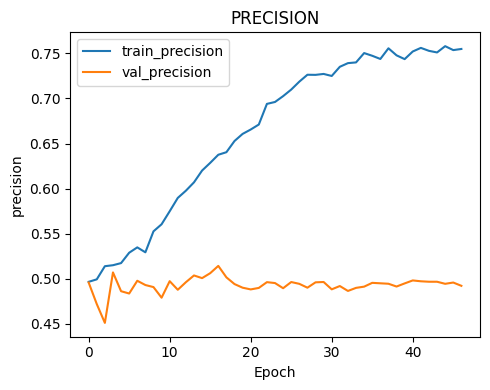

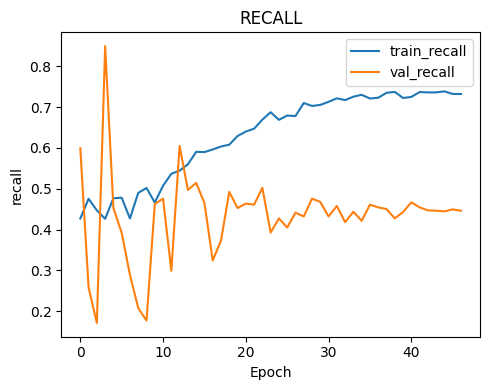

In [ ]:
#Visualizing model performance after every epoch
def plot_history(h):
    metrics = ['loss', 'accuracy', 'auc', 'precision', 'recall']

    #Plotting training vs validation curves
    for m in metrics:
        if m in h.history:
            plt.figure(figsize=(5,4))
            plt.plot(h.history[m], label=f"train_{m}")
            plt.plot(h.history[f"val_{m}"], label=f"val_{m}")
            plt.title(m.upper())
            plt.xlabel("Epoch")
            plt.ylabel(m)
            plt.legend()
            plt.tight_layout()
            plt.show()

plot_history(history)

In [ ]:
#Base case: evaluating on test set
y_proba = model.predict(X_test).ravel()
y_pred  = (y_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
try:
    auc = roc_auc_score(y_test, y_proba)
except ValueError:
    auc = float('nan')

print(f"Test Accuracy  : {acc:.4f}")
print(f"Test Precision : {prec:.4f}")
print(f"Test Recall    : {rec:.4f}")
print(f"Test F1        : {f1:.4f}")
print(f"Test ROC-AUC   : {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy  : 0.4927
Test Precision : 0.4862
Test Recall    : 0.3313
Test F1        : 0.3941
Test ROC-AUC   : 0.4873

Classification Report:
              precision    recall  f1-score   support

         0.0     0.4960    0.6527    0.5636      1506
         1.0     0.4862    0.3313    0.3941      1494

    accuracy                         0.4927      3000
   macro avg     0.4911    0.4920    0.4789      3000
weighted avg     0.4911    0.4927    0.4792      3000



In [ ]:
#Comparing Multiple MLP variants
configs = [
    {"hidden_layers": (256, 128, 64), "dropout": 0.3, "l2_reg": 1e-4, "lr": 1e-3},  #Base
    {"hidden_layers": (128, 64), "dropout": 0.3, "l2_reg": 1e-4, "lr": 1e-3},
    {"hidden_layers": (128, 64), "dropout": 0.5, "l2_reg": 5e-4, "lr": 1e-3},
]

results = []

for cfg in configs:
    print(f"Training configuration: {cfg}")
    m = build_mlp(input_dim=X_train.shape[1], **cfg)
    h = m.fit(
        X_train, y_train,
        validation_split=0.2, epochs=60, batch_size=64,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    #Evaluate on test set
    y_proba = m.predict(X_test).ravel()
    y_pred = (y_proba >= 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    auc = roc_auc_score(y_test, y_proba)
    results.append({**cfg, "acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc})

Training configuration: {'hidden_layers': (128, 64), 'dropout': 0.3, 'l2_reg': 0.0001, 'lr': 0.001}

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 22: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 27: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 32: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training configuration: {'hidden_layers': (256, 128, 64), 'dropout': 0.3, 'l2_reg': 0.0001, 'lr': 0.001}

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 21: ReduceLROnPlateau reducing learning rate to 6

In [ ]:
#Table to compare configuration performances
cv_df = pd.DataFrame(results)
display(cv_df.sort_values("f1", ascending=False))

,hidden_layers,dropout,l2_reg,lr,acc,prec,rec,f1,auc
0,"(128, 64)",0.3,0.0001,0.001,0.505333,0.502463,0.682731,0.578888,0.506165
2,"(128, 64)",0.5,0.0005,0.001,0.502000,0.500000,0.521419,0.510485,0.500036
1,"(256, 128, 64)",0.3,0.0001,0.001,0.505667,0.508296,0.225569,0.312471,0.507047


In [ ]:
#Rebuilding the best-performing MLP

best = cv_df.sort_values("f1", ascending=False).iloc[0]
best_cfg = {k: best[k] for k in ["hidden_layers","dropout","l2_reg","lr"]}
print("Best configuration:", best_cfg)

final_model = build_mlp(input_dim=X_train.shape[1], **best_cfg)
final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

#Evaluating final chosen model on test set
y_proba = final_model.predict(X_test).ravel()
y_pred  = (y_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print(f"\nFinal Selected MLP Results:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")

Best configuration: {'hidden_layers': (128, 64), 'dropout': np.float64(0.3), 'l2_reg': np.float64(0.0001), 'lr': np.float64(0.001)}
Epoch 1/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5059 - auc: 0.5090 - loss: 0.7208 - precision: 0.5108 - recall: 0.5162 - val_accuracy: 0.5008 - val_auc: 0.4956 - val_loss: 0.7093 - val_precision: 0.5078 - val_recall: 0.4560 - learning_rate: 0.0010
Epoch 2/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5154 - auc: 0.5230 - loss: 0.7086 - precision: 0.5132 - recall: 0.5055 - val_accuracy: 0.4904 - val_auc: 0.4802 - val_loss: 0.7095 - val_precision: 0.4970 - val_recall: 0.5465 - learning_rate: 0.0010
Epoch 3/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5304 - auc: 0.5328 - loss: 0.7058 - precision: 0.5262 - recall: 0.4518 - val_accuracy: 0.4771 - val_auc: 0.4796 - val_loss: 0.7078 - val_precision: 0.4851 - val_recall: 0.5342 - learning_rate: 0.0010
Epoch 4/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5292

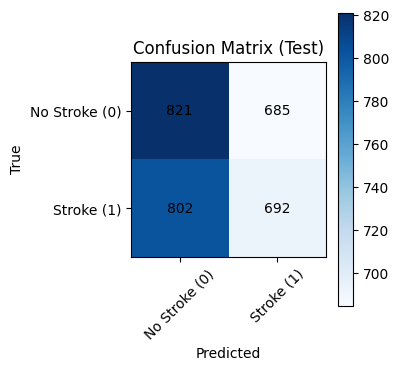

In [ ]:
#Displaying Confusion Matrix
from itertools import product

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Stroke (0)', 'Stroke (1)'], rotation=45)
plt.yticks(tick_marks, ['No Stroke (0)', 'Stroke (1)'])
for (i, j) in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

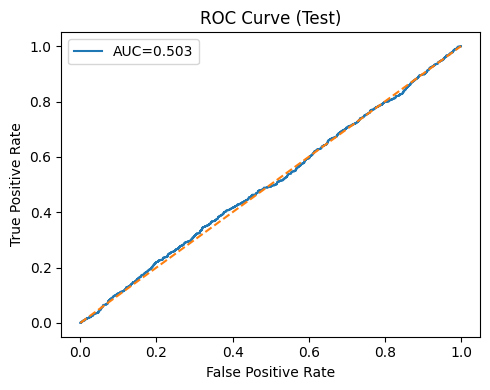

In [ ]:
#Displaying ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.title("ROC Curve (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

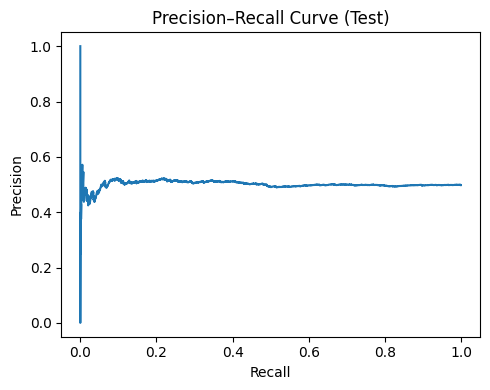

In [ ]:
#Displaying Precision-Recall curve
precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(recalls, precisions)
plt.title("Precision–Recall Curve (Test)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()